## Setup 
The below pulls `fluview` *ILI* data for the regions `nat`, National, and `al`, Alabama. 
By initializing `start_date=201650`, `end_date=201839` and `init_window_size=3` we fix an initial training window size of 3 time steps, so the `asof` reconstruction is only available from `201752` and on. 
By letting `persist=True`, the cached intermediate data files are stored on your local disk. This prevents one from having to call `Dataset` after every run. Otherwise, the intermediate data files are stored in a `temp` folder and will be terminated after every run. If you would like to view all the intermediate files, you can specify the path in `cache_dir`. 

> [!WARNING]
> `Dataset` will **take a while** upon first call. This is because one API call per time step is necessary to load all the intermediate files. After the initial `Dataset` call, calling `asof` to obtain your versioned dataset is instantaneous.

In [1]:
from asof import Dataset
from asof.sources import DelphiEpidata

# Optional: load API key from your .env file
from dotenv import load_dotenv
import os
load_dotenv()
API_KEY = os.getenv("DELPHI_API_KEY")

# Initialize fluview data
wili_data = Dataset(
    data_source=DelphiEpidata(
        series="fluview",
        regions=["nat","al"],
        api_key= API_KEY,  # add your API key here
    ),
    start_date=201650,
    end_date=201839,
    init_window_size=3, #  dictates initial training window (here it would be 201701)
    cache_dir= None, # optional: where you want cached intermediate files to live
    persist=True
)

Building cache (2 entities): 100%|██████████| 92/92 [01:58<00:00,  1.29s/version]


Now let's compare how the `asof` snapshot compares to the finalized version. Note, in the `epidata` API, if you do not specify any additional parameters, the default when setting the range for any dates is to return the most up to date numbers. 

In [2]:
import pandas as pd 
from delphi_epidata import Epidata

versioned_df = wili_data.asof(201701,entity="nat")
finalized_df = pd.DataFrame(Epidata.fluview(["nat"], 
                                            epiweeks=Epidata.range(201650,201701))['epidata']) #type:ignore

Now, let's take a peak at both version, we only have 4 observations after all. 

In [3]:
versioned_df

,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,num_age_0,num_age_1,num_age_2,num_age_3,num_age_4,num_age_5,wili,ili
0,2017-01-13,nat,201701,201650,3,18203,769850,1871,5614,6559,None,3486,1521,1023,2.20920,2.36449
1,2017-01-13,nat,201701,201651,2,20835,691836,1817,6395,7162,None,3992,1910,1376,2.73667,3.01155
2,2017-01-13,nat,201701,201652,1,23373,641257,1720,7320,6668,None,4960,2463,1962,3.34283,3.64487
3,2017-01-13,nat,201701,201701,0,21379,652828,1617,6019,5861,None,5122,2465,1912,3.18416,3.27483


In [4]:
finalized_df

,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,num_age_0,num_age_1,num_age_2,num_age_3,num_age_4,num_age_5,wili,ili
0,2018-10-05,nat,201839,201650,93,18463,811687,2005,5744,6724,None,3491,1485,1019,2.20671,2.27465
1,2018-10-05,nat,201839,201651,92,21570,740295,1982,6657,7470,None,4099,1923,1421,2.73096,2.91370
2,2018-10-05,nat,201839,201652,91,24900,701866,1931,7712,7144,None,5247,2652,2145,3.36152,3.54769
3,2018-10-05,nat,201839,201701,90,24178,785080,2028,6716,6786,None,5673,2773,2230,3.09232,3.07969


One can immediately note that the `versioned_df` is fixed as of the `201701` issue, which would be all we know `asof=201701`. One can see the `lag` parameters in `finalized_df` and `versioned_df` which shows how many weeks behind the data is. In the `versioned_df`, the `epiweek=201701` is appropriately `lag=0`, while we note `lag=90` for `epiweek=201701` in the `finalized_df`. 

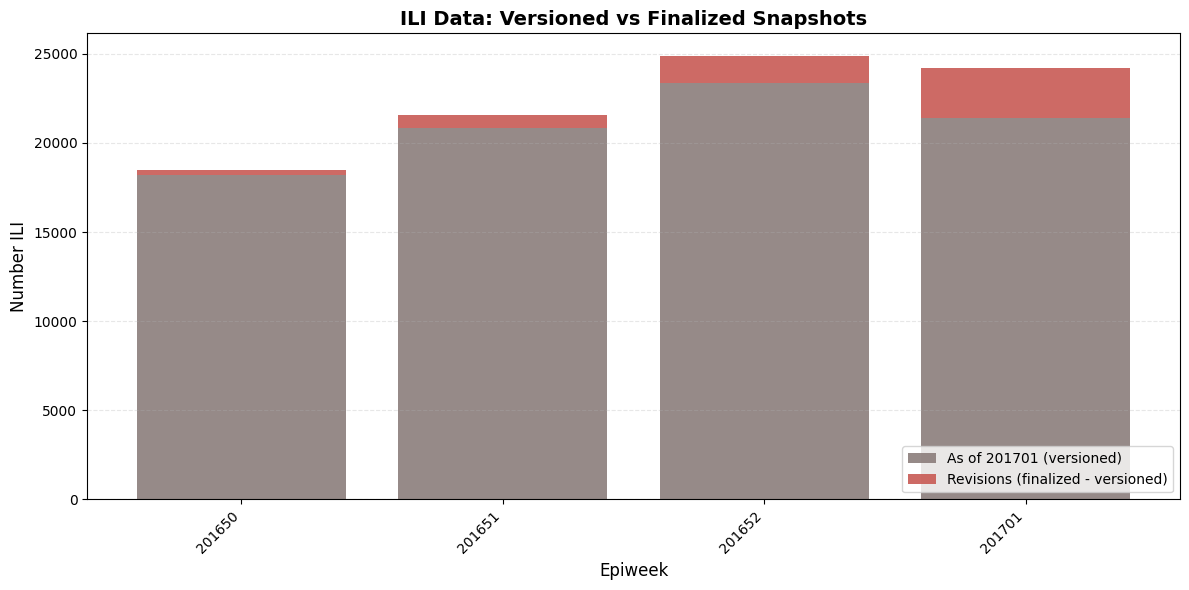

In [9]:
import matplotlib.pyplot as plt
import numpy as np


# Merge the two dataframes on epiweek to align them
merged = versioned_df.merge(
    finalized_df,
    on=['epiweek', 'region'],
    suffixes=('_versioned', '_finalized')
)

# Calculate the revision amount
merged['revision'] = merged['num_ili_finalized'] - merged['num_ili_versioned']


fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(merged))
width = 0.8
# stacked bars
ax.bar(x, merged['num_ili_versioned'], width, label='As of 201701 (versioned)', 
       color='#8B7D7B', alpha=0.9)
ax.bar(x, merged['revision'], width, bottom=merged['num_ili_versioned'],
       label='Revisions (finalized - versioned)', color='#C85A54', alpha=0.9)
ax.set_xlabel('Epiweek', fontsize=12)
ax.set_ylabel('Number ILI', fontsize=12)
ax.set_title('ILI Data: Versioned vs Finalized Snapshots', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(merged['epiweek'], rotation=45, ha='right')
ax.legend(loc='lower right')  # Changed from 'upper right' to 'lower right'
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

For good measure, we can calculate the percentage change between the versioned and the finalized data, `asof=201701`. We see that there was over a 13% difference between the initial `201701` release and the finalized one. 

In [8]:
# Calculate percent change
merged['percent_change'] = ((merged['num_ili_finalized'] - merged['num_ili_versioned']) / merged['num_ili_versioned'] * 100).round(2)

# Create summary table
summary = merged[['epiweek', 'percent_change']].copy()
summary.columns = ['Epiweek', 'Percent Change (%)']

print(summary)

   Epiweek  Percent Change (%)
0   201650                1.43
1   201651                3.53
2   201652                6.53
3   201701               13.09
